首先导入相关的库，注意安装autogluon的时候记得关VPN，不然pycharm老是在报错

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

读取数据，这里使用的是m4的小时数据集，总共有148060行数据，每行数据有三列
一列是物品名称，item_id,一列是时间戳，timestamp，一列是目标值，target

In [9]:
df = pd.read_csv("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/train.csv")
df

,item_id,timestamp,target
0,H1,1750-01-01 00:00:00,605.0
1,H1,1750-01-01 01:00:00,586.0
2,H1,1750-01-01 02:00:00,586.0
3,H1,1750-01-01 03:00:00,559.0
4,H1,1750-01-01 04:00:00,511.0
...,...,...,...
148055,H200,1750-02-09 19:00:00,24.2
148056,H200,1750-02-09 20:00:00,22.6
148057,H200,1750-02-09 21:00:00,20.8
148058,H200,1750-02-09 22:00:00,19.6


# autogluon对数据格式的要求
1. 独特的时间序列id，可为int或者str类型
2. 时间戳必须是满足pd.Timestamp的格式 2018-03-17 22:15:15
3. 数值型的目标值target
至少要有这三列，其他的列可以有，也可以没有
但是我们在创造TimeSeriesDataFrame的时候，需要指定哪一列是时间序列id，哪一列是时间戳，哪一列是目标值
如果格式不匹配，会报错

In [7]:
train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="item_id",
    timestamp_column="timestamp"
)
train_data

target
item_id timestamp                  
H1      1750-01-01 00:00:00   605.0
        1750-01-01 01:00:00   586.0
        1750-01-01 02:00:00   586.0
        1750-01-01 03:00:00   559.0
        1750-01-01 04:00:00   511.0
...                             ...
H200    1750-02-09 19:00:00    24.2
        1750-02-09 20:00:00    22.6
        1750-02-09 21:00:00    20.8
        1750-02-09 22:00:00    19.6
        1750-02-09 23:00:00    18.8

[148060 rows x 1 columns]

我们可以看到，train_data的格式是TimeSeriesDataFrame，这是autogluon自己定义的数据格式
H1表示的是一只股票的时间序列，H2表示的是另一只股票的时间序列
Autogluon单独为每个时间序列生成预测,并不是对不同的序列之间的交互进行预测
同时为了预测未来的值我们需要创建一个time series predictor
prediction_length表示的是我们要预测的未来的时间长度,这里我们预测未来48个小时的值
path表示的是我们训练好的模型的保存路径
target表示的是我们要预测的目标值
eval_metric表示的是我们的评估指标，这里我们使用的是MASE
presets表示训练的质量,还有选择是high_quality但是训练时间会更长
time_limit表示的是训练的时间限制，这里我们设置的是600秒
autogluon会自动选择最好的模型，我们也可以自己指定模型

In [4]:
predictor = TimeSeriesPredictor(
    prediction_length=48,
    path="autogluon-m4-hourly",
    target="target",
    eval_metric="MASE",
)

predictor.fit(
    train_data,
    presets="medium_quality",
    time_limit=600,
)

================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: medium_quality
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'MASE',
 'excluded_model_types': None,
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'medium_quality',
 'num_val_windows': 1,
 'prediction_length': 48,
 'random_seed': None,
 'target': 'target',
 'time_limit': 600,
 'verbosity': 2}
Provided training data set with 148060 rows, 200 items (item = single time series). Average time series length is 740.3. Data frequency is 'H'.
AutoGluon will save models to autogluon-m4-hourly\
AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.

Provided dataset contains following columns:
	target:           'target'

Starting training. Start time is 2023-08-22 21:11:25
Models that will be 

autogluon还会产生概率预测,它还提供分布的置信区间,让我们了解结果的可能范围
for example,0.1表示你有10%的可能性会低于这个值(有点类似正态分布

In [6]:
predictions = predictor.predict(train_data)
predictions

Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: RecursiveTabular


mean         0.1         0.2         0.3  \
item_id timestamp                                                             
H1      1750-01-30 04:00:00  621.022377  591.515051  601.644310  608.948218   
        1750-01-30 05:00:00  555.173747  513.444087  527.769022  538.098308   
        1750-01-30 06:00:00  512.971912  461.863725  479.408116  492.058856   
        1750-01-30 07:00:00  478.888969  419.874318  440.132836  454.740653   
        1750-01-30 08:00:00  456.222546  390.242160  412.891872  429.223907   
...                                 ...         ...         ...         ...   
H200    1750-02-11 19:00:00   24.316481   23.960590   24.082760   24.170853   
        1750-02-11 20:00:00   22.688902   22.328990   22.452540   22.541629   
        1750-02-11 21:00:00   20.915038   20.551149   20.676064   20.766137   
        1750-02-11 22:00:00   19.757972   19.390148   19.516415   19.607461   
        1750-02-11 23:00:00   18.895092   18.523376   18.650978   18.742988   

                                    0.4         0.5         0.6         0.7  \
item_id timestamp                                                             
H1      1750-01-30 04:00:00  615.189139  621.022377  626.855615  633.096535   
        1750-01-30 05:00:00  546.924302  555.173747  563.423191  572.249185   
        1750-01-30 06:00:00  502.868447  512.971912  523.075377  533.884968   
        1750-01-30 07:00:00  467.222493  478.888969  490.555446  503.037286   
        1750-01-30 08:00:00  443.179029  456.222546  469.266063  483.221185   
...                                 ...         ...         ...         ...   
H200    1750-02-11 19:00:00   24.246126   24.316481   24.386836   24.462109   
        1750-02-11 20:00:00   22.617752   22.688902   22.760053   22.836176   
        1750-02-11 21:00:00   20.843102   20.915038   20.986975   21.063939   
        1750-02-11 22:00:00   19.685258   19.757972   19.830686   19.908482   
        1750-02-11 23:00:00   18.821608   18.895092   18.968575   19.047195   

                                    0.8         0.9  
item_id timestamp                                    
H1      1750-01-30 04:00:00  640.400443  650.529702  
        1750-01-30 05:00:00  582.578471  596.903406  
        1750-01-30 06:00:00  546.535708  564.080099  
        1750-01-30 07:00:00  517.645103  537.903620  
        1750-01-30 08:00:00  499.553220  522.202931  
...                                 ...         ...  
H200    1750-02-11 19:00:00   24.550202   24.672372  
        1750-02-11 20:00:00   22.925264   23.048815  
        1750-02-11 21:00:00   21.154012   21.278928  
        1750-02-11 22:00:00   19.999529   20.125795  
        1750-02-11 23:00:00   19.139205   19.266808  

[9600 rows x 10 columns]

我们现在可视化一下预测的结果和真实值的对比
我们绘制 mean forecast 以及0.1和0.9所在的置信区间

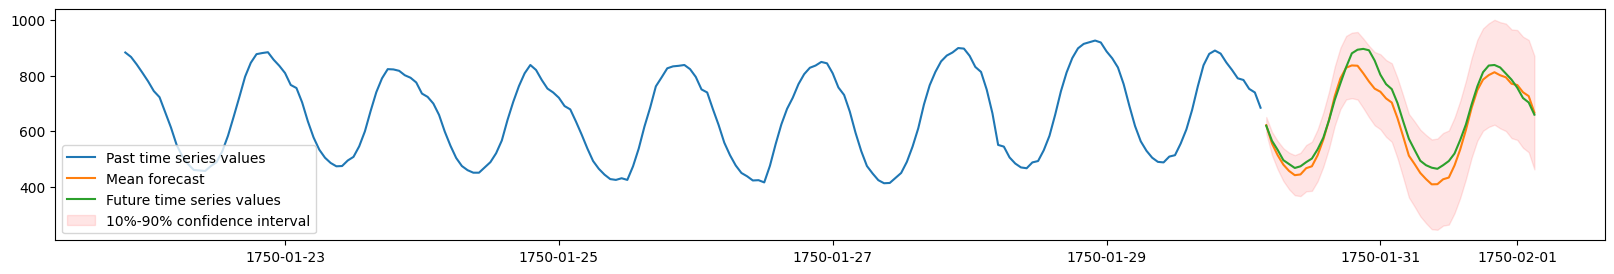

In [10]:
import matplotlib.pyplot as plt

# TimeSeriesDataFrame can also be loaded directly from a file
test_data = TimeSeriesDataFrame.from_path("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/test.csv")

plt.figure(figsize=(20, 3))

item_id = "H1"
y_past = train_data.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"][-48:]

plt.plot(y_past[-200:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend();

# 评估不同模型的效果
我们可以使用autogluon的leaderboard来评估不同模型的效果

In [11]:
# The test score is computed using the last
# prediction_length=48 timesteps of each time series in test_data
predictor.leaderboard(test_data, silent=True)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,RecursiveTabular,-0.870271,-0.898770,2.065718,2.980151,11.563823,5
1,SeasonalNaive,-1.022854,-1.216909,0.281840,0.262112,0.163962,2
2,DeepAR,-1.527105,-1.656794,21.428722,17.207482,482.996911,6
3,AutoETS,-1.778462,-1.939952,87.875800,56.299856,0.159904,4
4,Theta,-1.905365,-2.142531,52.613042,38.779207,0.162379,3
5,Naive,-6.696079,-6.662942,8.652925,7.177318,0.165136,1


# 总结
1. autogluon不需要调参数
2. 数据结构一定要满足time series dataframe的要求